In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
x = mnist.data
y = mnist.target

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random 

In [0]:
def loss_grad_softmax_naive(W, X, y, reg):
    """
    Compute the loss and gradients using softmax function 
    with loop, which is slow.
    Parameters
    ----------
    W: (K, D) array of weights, K is the number of classes and D is the dimension of one sample.
    X: (D, N) array of training data, each column is a training sample with D-dimension.
    y: (N, ) 1-dimension array of target data with length N with lables 0,1, ... K-1, for K classes
    reg: (float) regularization strength for optimization.
    Returns
    -------
    a tuple of two items (loss, grad)
    loss: (float)
    grad: (K, D) with respect to W
    """
    loss = 0
    grad = np.zeros_like(W)
    dim, num_train = X.shape
    num_classes = W.shape[0]
    for i in range(num_train):
        sample_x = X[:, i]
        scores = np.zeros(num_classes) # [K, 1] unnormalized score
        for cls in range(num_classes):
            w = W[cls, :]
            scores[cls] = w.dot(sample_x)
        # Shift the scores so that the highest value is 0
        scores -= np.max(scores)
        correct_class = y[i]
        sum_exp_scores = np.sum(np.exp(scores))
        corr_cls_exp_score = np.exp(scores[int(correct_class)])
        loss_x = -np.log(corr_cls_exp_score / sum_exp_scores)
        loss += loss_x

        # compute the gradient
        percent_exp_score = np.exp(scores) / sum_exp_scores
        for j in range(num_classes):
            grad[j, :] += percent_exp_score[j] * sample_x


        grad[int(correct_class), :] -= sample_x # deal with the correct class

    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W) # add regularization
    grad /= num_train
    grad += reg * W
    return loss, grad

def loss_grad_softmax_vectorized(W, X, y, reg):
    """ Compute the loss and gradients using softmax with vectorized version"""
    loss = 0 
    grad = np.zeros_like(W)
    dim, num_train = X.shape

    scores = W.dot(X) # [K, N]
    # Shift scores so that the highest value is 0
    scores -= np.max(scores)
    scores_exp = np.exp(scores)
    # print(int(y))
    correct_scores_exp = scores_exp[y.astype(int), range(num_train)] # [N, ]
    scores_exp_sum = np.sum(scores_exp, axis=0) # [N, ]
    loss = -np.sum(np.log(correct_scores_exp / scores_exp_sum))
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)

    scores_exp_normalized = scores_exp / scores_exp_sum
    # deal with the correct class
    scores_exp_normalized[y.astype(int), range(num_train)] -= 1 # [K, N]
    grad = scores_exp_normalized.dot(X.T)
    grad /= num_train
    grad += reg * W

    return loss, grad

In [0]:
import numpy as np
# from algorithms.classifiers.loss_grad_logistic import *
# from algorithms.classifiers.loss_grad_softmax import *
# from algorithms.classifiers.loss_grad_svm import *

class LinearClassifier:

    def __init__(self):
        self.W = None # set up the weight matrix 

    def train(self, X, y, method='sgd', batch_size=200, learning_rate=1e-4,
              reg = 1e3, num_iters=1000, verbose=False, vectorized=True):
        """
        Train linear classifer using batch gradient descent or stochastic gradient descent
        Parameters
        ----------
        X: (D x N) array of training data, each column is a training sample with D-dimension.
        y: (N, ) 1-dimension array of target data with length N.
        method: (string) determine whether using 'bgd' or 'sgd'.
        batch_size: (integer) number of training examples to use at each step.
        learning_rate: (float) learning rate for optimization.
        reg: (float) regularization strength for optimization.
        num_iters: (integer) number of steps to take when optimization.
        verbose: (boolean) if True, print out the progress (loss) when optimization.
        Returns
        -------
        losses_history: (list) of losses at each training iteration
        """

        dim, num_train = X.shape
        
        num_classes = np.max(y.astype(int)) + 1 # assume y takes values 0...K-1 where K is number of classes

        if self.W is None:
            # initialize the weights with small values
            if num_classes == 2: # just need weights for one class
                self.W = np.random.randn(1, dim) * 0.001
            else: # weigths for each class
                self.W = np.random.randn(num_classes, dim) * 0.001

        losses_history = []

        for i in range(num_iters):
            if method == 'bgd':
                loss, grad = self.loss_grad(X, y, reg, vectorized)
            else:
                # randomly choose a min-batch of samples
                idxs = np.random.choice(num_train, batch_size, replace=False)
                loss, grad = self.loss_grad(X[:, idxs], y[idxs], reg, vectorized) # grad => [K x D]
                
            losses_history.append(loss)
            # update weights
            self.W -= learning_rate * grad # [K x D]
            # print self.W
            # print 'dsfad', grad.shape
            if verbose and (i % 100 == 0):
                print('iteration %d/%d: loss %f' % (i, num_iters, loss))

        return losses_history

    def predict(self, X):
        """
        Predict value of y using trained weights
        Parameters
        ----------
        X: (D x N) array of data, each column is a sample with D-dimension.
        Returns
        -------
        pred_ys: (N, ) 1-dimension array of y for N sampels
        h_x_mat: Normalized scores
        """
        pred_ys = np.zeros(X.shape[1])
        f_x_mat = self.W.dot(X)
        if self.__class__.__name__ == 'Logistic':
            pred_ys = f_x_mat.squeeze() >=0
        else: # multiclassification
            pred_ys = np.argmax(f_x_mat, axis=0)
        # normalized score
        h_x_mat = 1.0 / (1.0 + np.exp(-f_x_mat)) # [1, N]
        h_x_mat = h_x_mat.squeeze()
        # print(pred_ys)
        # print(h_x_mat)
        return pred_ys, h_x_mat

    def loss_grad(self, X, y, reg, vectorized=True):
        """
        Compute the loss and gradients.
        Parameters
        ----------
        The same as self.train()
        Returns
        -------
        a tuple of two items (loss, grad)
        loss: (float)
        grad: (array) with respect to self.W
        """
        pass


# Subclasses of linear classifier
class Logistic(LinearClassifier):
    """A subclass for binary classification using logistic function"""
    def loss_grad(self, X, y, reg, vectorized=True):
        if vectorized:
            return loss_grad_logistic_vectorized(self.W, X, y, reg)
        else:
            return loss_grad_logistic_naive(self.W, X, y, reg)


class Softmax(LinearClassifier):
    """A subclass for multi-classicication using Softmax function"""
    def loss_grad(self, X, y, reg, vectorized=True):
        if vectorized:
            return loss_grad_softmax_vectorized(self.W, X, y, reg)
        else:
            return loss_grad_softmax_naive(self.W, X, y, reg)


class SVM(LinearClassifier):
    """A subclass for multi-classicication using SVM function"""
    def loss_grad(self, X, y, reg, vectorized=True):
        return loss_grad_svm_vectorized(self.W, X, y, reg)


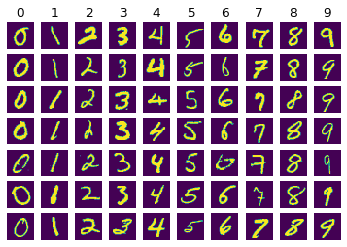

Train data shape:  (785, 50000)
Train labels shape:  (50000,)
Validation data shape:  (785, 10000)
Validation labels shape:  (10000,)
Test data shape:  (785, 10000)
Test labels shape:  (10000,)


In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random 

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

def get_mnist_data(num_training=50000, num_val=10000, num_test=10000, show_sample=True):
    """
    Load the CIFAR-10 dataset, and divide the sample into training set, validation set and test set
    """

    cifar10_dir = 'datasets/datasets-cifar-10/cifar-10-batches-py/'
    X_train1, X_test, y_train1, y_test = train_test_split(x,y,test_size=10000)
    
    X_train = X_train1[:num_training]
    y_train = y_train1[:num_training]    
    # subsample the data for validation set
    X_val = X_train1[num_training:]
    y_val = y_train1[num_training:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        
        idxs = np.flatnonzero(y_train == str(y)) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(np.reshape(X_train[idx].astype('uint8'),(28,28)))  #np.reshape(out[0]*255,(224,224))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
def preprocessing_mnist_data(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) # [49000, 3072]
    X_val = np.reshape(X_val, (X_val.shape[0], -1)) # [1000, 3072]
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) # [10000, 3072]
    # print(np.flatnonzero((X_train)[0]))
    # Normalize the data: subtract the mean image
    # mean_image = np.mean(X_train, axis = 0)
    # X_train -= mean_image
    # X_val -= mean_image
    # X_test -= mean_image

    # Add bias dimension and transform into columns
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1)))).T
    X_val = np.hstack((X_val, np.ones((X_val.shape[0], 1)))).T
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))).T

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above functions to get our data
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = get_mnist_data()
visualize_sample(X_train_raw, y_train_raw, classes)

X_train, y_train, X_val, y_val, X_test, y_test = preprocessing_mnist_data(X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw)

# As a sanity check, we print out th size of the training and test data dimenstion
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


In [0]:
#from algorithms.classifiers import loss_grad_softmax_naive, loss_grad_softmax_vectorized
import time

# generate a rand weights W 
W = np.random.randn(10, X_train.shape[0]) * 0.001
tic = time.time()
loss_naive, grad_naive = loss_grad_softmax_naive(W, X_train, y_train, 0.0001)
toc = time.time()
print('Naive loss: %f, and gradient: computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vec, grad_vect = loss_grad_softmax_vectorized(W, X_train, y_train, 0.0001)
toc = time.time()
print('Vectorized loss: %f, and gradient: computed in %fs' % (loss_vec, toc - tic))

# Compare the gradient, because the gradient is a vector, we canuse the Frobenius norm to compare them
# the Frobenius norm of two matrices is the square root of the squared sum of differences of all elements
diff = np.linalg.norm(grad_naive - grad_vect, ord='fro')
# Randomly choose some gradient to check
idxs = np.random.choice(X_train.shape[0], 10, replace=False)
print(idxs)
print(grad_naive[0, idxs])
print(grad_vect[0, idxs])
print('Gradient difference between naive and vectorized version is: %f' % diff)
del loss_naive, loss_vec, grad_naive

Naive loss: 3.996153, and gradient: computed in 4.888870s
Vectorized loss: 3.996153, and gradient: computed in 0.292579s
[711 521 462 609 674 570  92 722 702 752]
[ 1.10914590e+00 -8.49837466e+00  3.70707602e+00 -1.31341518e+00
  5.04443235e-04 -1.04328705e+01  4.56743723e-02  1.50718117e-03
  1.57381043e-05  1.45493828e-05]
[ 1.10914590e+00 -8.49837466e+00  3.70707602e+00 -1.31341518e+00
  5.04443235e-04 -1.04328705e+01  4.56743723e-02  1.50718117e-03
  1.57381043e-05  1.45493828e-05]
Gradient difference between naive and vectorized version is: 0.000000


In [0]:
# file: algorithms/gradient_check.py
from random import randrange
def grad_check_sparse(f, x, analytic_grad, num_checks):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """
  h = 1e-5

  print(x.shape)

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])
    print(ix)
    x[ix] += h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] -= 2 * h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] += h # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [0]:
# Check gradient using numerical gradient along several randomly chosen dimenstion
f = lambda w: loss_grad_softmax_vectorized(w, X_train, y_train, 0)[0]
grad_numerical = grad_check_sparse(f, W, grad_vect, 10)

(10, 785)
(6, 53)
numerical: 0.000000 analytic: 0.000000, relative error: 1.000000e+00
(2, 614)
numerical: -0.035584 analytic: -0.035584, relative error: 1.234708e-06
(7, 336)
numerical: 0.000000 analytic: -0.000000, relative error: 1.000000e+00
(3, 671)
numerical: 0.000000 analytic: 0.000000, relative error: 1.000000e+00
(7, 430)
numerical: 31.895413 analytic: 31.895411, relative error: 2.164904e-08
(3, 129)
numerical: -1.381416 analytic: -1.381417, relative error: 2.870702e-07
(1, 244)
numerical: 0.774376 analytic: 0.774375, relative error: 7.193545e-07
(4, 375)
numerical: -8.941478 analytic: -8.941478, relative error: 3.073808e-08
(9, 152)
numerical: 0.246961 analytic: 0.246961, relative error: 9.297431e-07
(5, 774)
numerical: 0.001069 analytic: 0.001069, relative error: 4.970310e-05


In [0]:
softmax_sgd = Softmax()
tic = time.time()
losses_sgd = softmax_sgd.train(X_train, y_train, method='sgd', batch_size=200, learning_rate=1e-6,
                               reg = 1e5, num_iters=1000, verbose=True, vectorized=True)
toc = time.time()
print('Traning time for SGD with vectorized version is %f \n' % (toc - tic))

y_train_pred_sgd = softmax_sgd.predict(X_train)[0]
print('Training accuracy: %f' % (np.mean(y_train.astype(int) == y_train_pred_sgd)))
y_val_pred_sgd= softmax_sgd.predict(X_val)[0]
print('Validation accuracy: %f' % (np.mean(y_val.astype(int) == y_val_pred_sgd)))

iteration 0/1000: loss 398.099885
iteration 100/1000: loss 2.038546
iteration 200/1000: loss 2.054587
iteration 300/1000: loss 2.025516
iteration 400/1000: loss 2.051416
iteration 500/1000: loss 2.021544
iteration 600/1000: loss 2.049318
iteration 700/1000: loss 1.993020
iteration 800/1000: loss 2.029770
iteration 900/1000: loss 2.019542
Traning time for SGD with vectorized version is 3.465394 

Training accuracy: 0.737520
Validation accuracy: 0.742100


In [0]:
# import pandas
# from pandas._libs import tslibs
# from ggplot import *
# qplot(range(len(losses_sgd)), losses_sgd) + labs(x='Iteration number', y='SGD Loss value')

In [0]:
# Using validation set to tuen hyperparameters, i.e., learning rate and regularization strength
learning_rates = [1e-5, 1e-8]
regularization_strengths = [10e2, 10e4]

# Result is a dictionary mapping tuples of the form (learning_rate, regularization_strength) 
# to tuples of the form (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1
best_softmax = None
# Choose the best hyperparameters by tuning on the validation set
i = 0
interval = 5
for learning_rate in np.linspace(learning_rates[0], learning_rates[1], num=interval):
    i += 1
    print('The current iteration is %d/%d' % (i, interval))
    for reg in np.linspace(regularization_strengths[0], regularization_strengths[1], num=interval):
        softmax = Softmax()
        softmax.train(X_train, y_train, method='sgd', batch_size=200, learning_rate=learning_rate,
              reg = reg, num_iters=1000, verbose=False, vectorized=True)
        y_train_pred = softmax.predict(X_train)[0]
        y_val_pred = softmax.predict(X_val)[0]
        train_accuracy = np.mean(y_train.astype(int) == y_train_pred)
        val_accuracy = np.mean(y_val.astype(int) == y_val_pred)
        results[(learning_rate, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
        else:
            pass

# Print out the results
for learning_rate, reg in sorted(results):
    train_accuracy,val_accuracy = results[(learning_rate, reg)]
    print('learning rate %e and regularization %e, \n \
    the training accuracy is: %f and validation accuracy is: %f.\n' % (learning_rate, reg, train_accuracy, val_accuracy))

The current iteration is 1/5
The current iteration is 2/5
The current iteration is 3/5
The current iteration is 4/5
The current iteration is 5/5
learning rate 1.000000e-08 and regularization 1.000000e+03, 
     the training accuracy is: 0.148760 and validation accuracy is: 0.148400.

learning rate 1.000000e-08 and regularization 2.575000e+04, 
     the training accuracy is: 0.170120 and validation accuracy is: 0.175500.

learning rate 1.000000e-08 and regularization 5.050000e+04, 
     the training accuracy is: 0.215320 and validation accuracy is: 0.211200.

learning rate 1.000000e-08 and regularization 7.525000e+04, 
     the training accuracy is: 0.195160 and validation accuracy is: 0.193400.

learning rate 1.000000e-08 and regularization 1.000000e+05, 
     the training accuracy is: 0.314420 and validation accuracy is: 0.310000.

learning rate 2.507500e-06 and regularization 1.000000e+03, 
     the training accuracy is: 0.890820 and validation accuracy is: 0.892300.

learning rate 2

In [0]:
y_test_predict_result = best_softmax.predict(X_test)
y_test_predict = y_test_predict_result[0]
test_accuracy = np.mean(y_test.astype(int) == y_test_predict)
print('The test accuracy is: %f' % test_accuracy)


The test accuracy is: 0.891200


Plotting the Given Input ----
The Predicted Result: 8


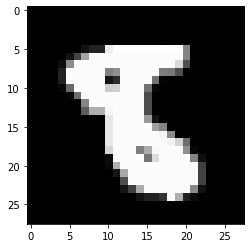

In [0]:
import matplotlib.pyplot as plt

tes = X_test[:,19]
tes = tes.reshape(785,1)
tes1 = tes[0:784,:]
print("Plotting the Given Input ----")
plt.imshow(np.reshape(tes1,(28,28)),cmap="gray")
plt.show

print("The Predicted Result:", y_test_predict[19])